!pip install imageio-ffmpeg

# Import Libaray

In [24]:
!pip install scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 2.9 MB/s eta 0:00:0000:0100:01
  Using cached tifffile-2023.8.12-py3-none-any.whl (220 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 1.5 MB/s eta 0:00:0000:0100:01
  Using cached lazy_loader-0.3-py3-none-any.whl (9.1 kB)

[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [25]:
import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from plyfile import PlyData
from skimage.metrics import structural_similarity

# Download Dataset

In [ ]:
# !wget https://people.eecs.berkeley.edu/~bmild/nerf/tiny_nerf_data.npz


# Read data and get images, pose and focal

(100, 100, 100, 3) (100, 4, 4) 1.0
tf.Tensor([100 100   3], shape=(3,), dtype=int32)


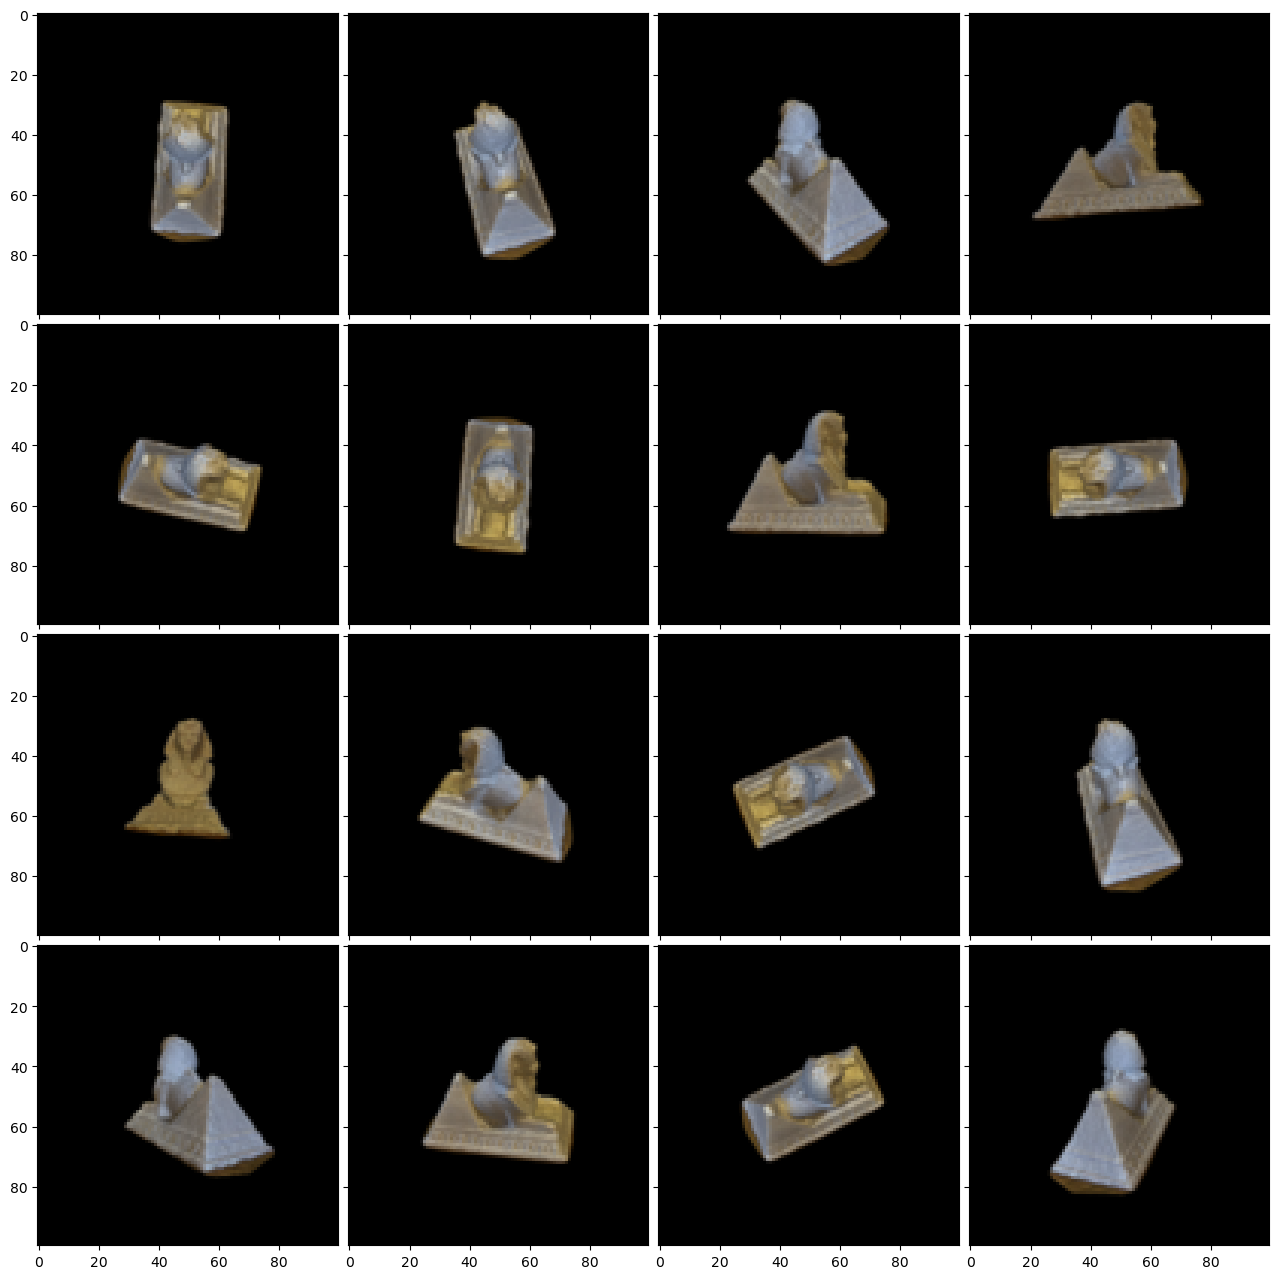

In [43]:
folder_path = './Dataset/egypt_picture_data'

file_names = os.listdir(folder_path)

images_data = []
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    
    img = Image.open(file_path)

    img = img.resize((200, 200))
    
    img_array = np.array(img)
    
    img_array = np.array(img) / 255.0
    
    if len(img_array.shape) == 3 and img_array.shape[2] == 3:
        images_data.append(img_array)

images = np.array(images_data)

poses_data = np.load('./Dataset/camera_positions.npz')
poses = poses_data['arr1']
focal = 1.0
focal = np.array(focal)

H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[99], poses[99]
print(tf.shape(testimg))
images = images[:90,...,:3]
poses = poses[:90]

from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)
random_images = images[np.random.choice(np.arange(images.shape[0]), 16)]
for ax, image in zip(grid, random_images):
    ax.imshow(image)
plt.title("Sample Images from model data")
plt.show()

[  0 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136
 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 247 248 249 250 251 252 253 254 255]


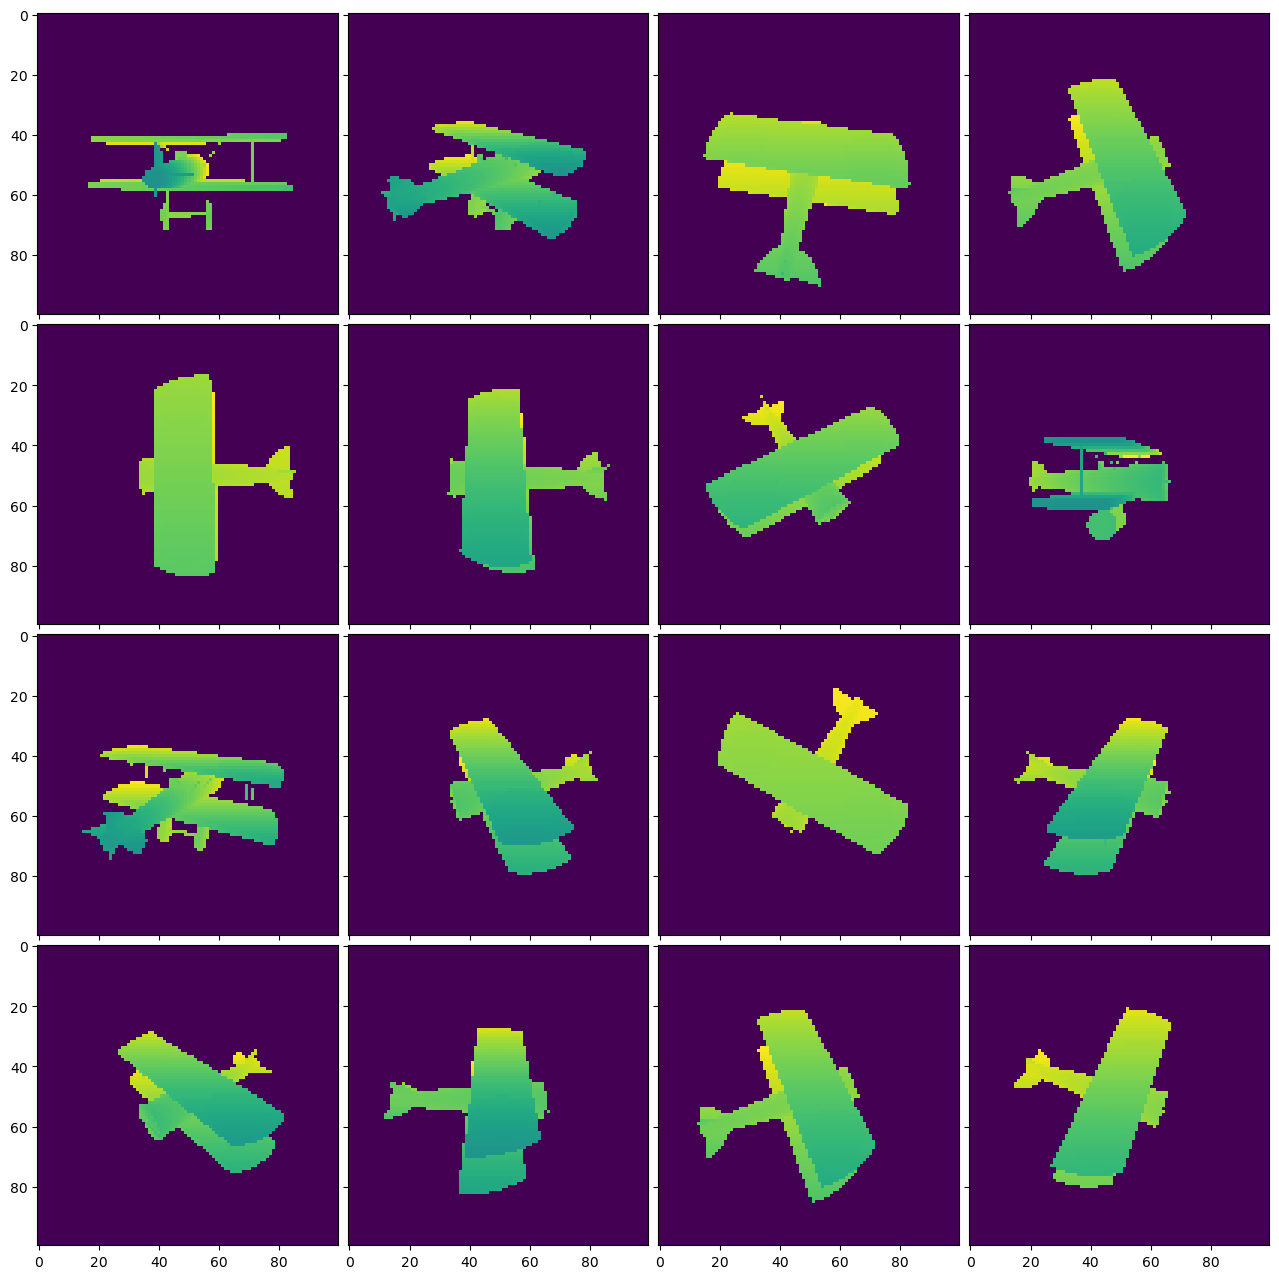

In [27]:
depth_path = './Dataset/model_depth_data'
depth_names = os.listdir(depth_path)
depths_data = []
for depth_name in depth_names:
    depth_file_path = os.path.join(depth_path, depth_name)
    depth_img = Image.open(depth_file_path)
    depth_img = depth_img.resize((100, 100))
    depth_array = np.array(depth_img)
    depths_data.append(depth_array)
    
depth_images = np.array(depths_data)
print(np.unique(depth_images))

fig = plt.figure(figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)
random_depth = depth_images[np.random.choice(np.arange(depth_images.shape[0]), 16)]
for ax, image in zip(grid, random_depth):
    ax.imshow(image)
plt.title("Sample Images from model Data")
plt.show()

# NeRF

In [28]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()    
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed)) 
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    # Create a 2D rectangular grid for the rays corresponding to image dimensions
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    # Normalize the x-axis coordinates
    transformed_i = (i - W * 0.5) / focal 
    # Normalize the y-axis coordinates
    transformed_j = -(j - H * 0.5) / focal 
    # z-axis coordinates
    k = -tf.ones_like(i) 
    # Create the unit vectors corresponding to ray directions
    dirs = tf.stack([transformed_i, transformed_j, k], -1)
    # Compute Origins and Directions for each ray
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    # rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    rays_o = tf.cast(tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d)), dtype=tf.float32)
    return rays_o, rays_d

In [35]:
def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    
    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples)
    if rand:
        z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far - near) / N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    # print('pts', tf.shape(pts))
    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    print('flat', tf.shape(pts_flat))
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])
    
    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3]) 
    # print(sigma_a)
    
    
    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-tf.exp(-sigma_a * dists)  
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    
    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2) 
    depth_map = tf.reduce_sum(weights * z_vals, -1) 
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map


flat tf.Tensor([640000      3], shape=(2,), dtype=int32)
0 1.5787202358245849 secs per iter
flat tf.Tensor([640000      3], shape=(2,), dtype=int32)
rgb shape tf.Tensor([100 100   3], shape=(3,), dtype=int32)


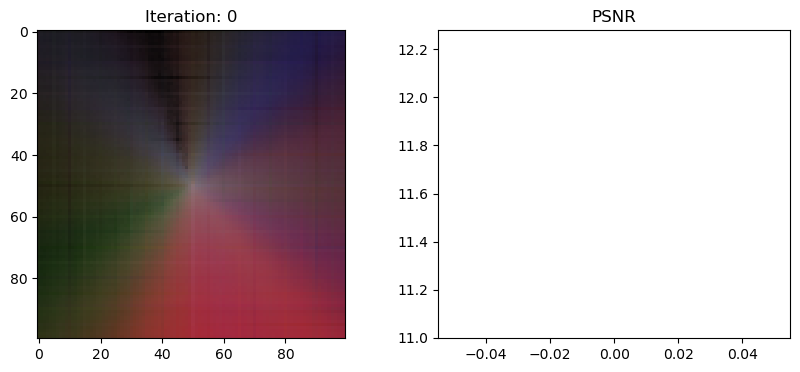

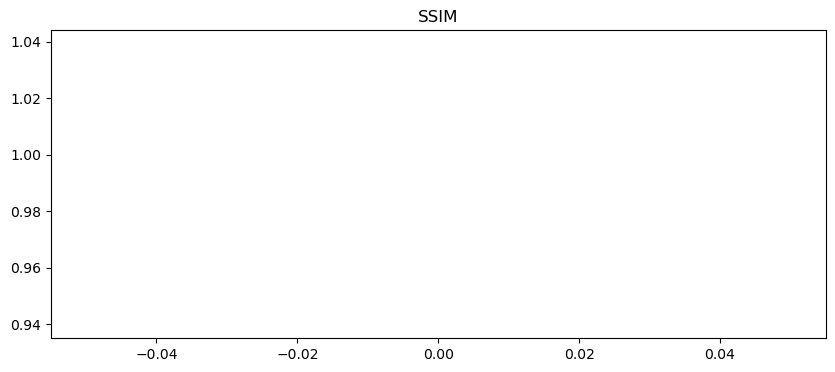

flat tf.Tensor([640000      3], shape=(2,), dtype=int32)
flat tf.Tensor([640000      3], shape=(2,), dtype=int32)
flat tf.Tensor([640000      3], shape=(2,), dtype=int32)
flat tf.Tensor([640000      3], shape=(2,), dtype=int32)
flat tf.Tensor([640000      3], shape=(2,), dtype=int32)
flat tf.Tensor([640000      3], shape=(2,), dtype=int32)
flat tf.Tensor([640000      3], shape=(2,), dtype=int32)
flat tf.Tensor([640000      3], shape=(2,), dtype=int32)
flat tf.Tensor([640000      3], shape=(2,), dtype=int32)
flat tf.Tensor([640000      3], shape=(2,), dtype=int32)
flat tf.Tensor([640000      3], shape=(2,), dtype=int32)
flat tf.Tensor([640000      3], shape=(2,), dtype=int32)
flat tf.Tensor([640000      3], shape=(2,), dtype=int32)
flat tf.Tensor([640000      3], shape=(2,), dtype=int32)
flat tf.Tensor([640000      3], shape=(2,), dtype=int32)
flat tf.Tensor([640000      3], shape=(2,), dtype=int32)
flat tf.Tensor([640000      3], shape=(2,), dtype=int32)
flat tf.Tensor([640000      3],

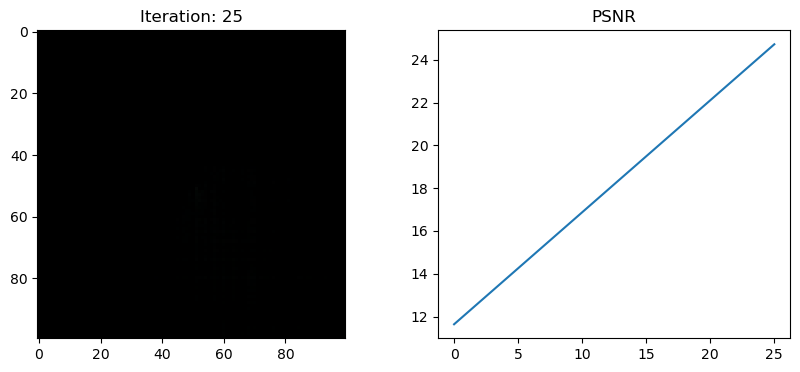

ValueError: x and y must have same first dimension, but have shapes (2,) and (1,)

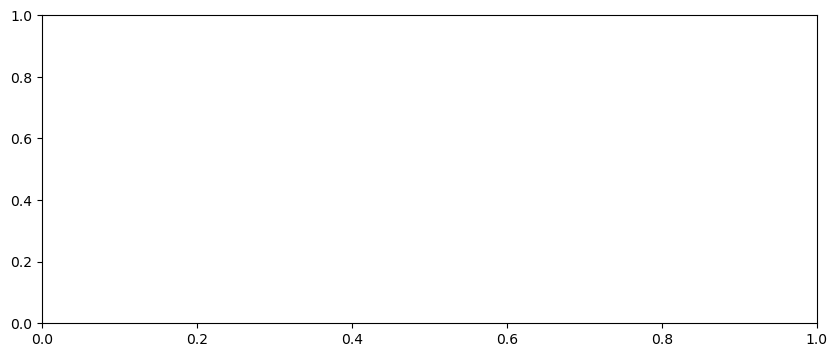

In [41]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

# Output view and Peak signal-to-noise ratio every 25 iterations
N_samples = 64
N_iters = 1000
psnrs = []
iternums = []
i_plot = 25

import time

t = time.time()
for i in range(N_iters+1):
    
    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    # print(target)
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    # print(tf.shape(rays_o))
    # print(tf.shape(rays_d))
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=0.1, far=10., N_samples=N_samples, rand=True)
        # print('acc', acc)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()
        
        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=0.1, far=10., N_samples=N_samples)
        print('rgb shape', tf.shape(rgb))
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        # Calculate SSIM
        testimg_float = tf.cast(testimg, tf.float32) / 255.0
        rgb_float = tf.cast(rgb, tf.float32) / 255.0
        ssim_value = tf.image.ssim(testimg_float, rgb_float, max_val=1.0)

        psnrs.append(psnr.numpy())
        iternums.append(i)
        
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

        plt.figure(figsize=(10,4))
        plt.plot(iternums, ssim_value)
        plt.title('SSIM')
        plt.show()

print('Done')

# Visualization

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)

def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()
    

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

# interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
# output = interactive_plot.children[-1]
# output.layout.height = '350px'
# interactive_plot

In [ ]:
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
from tqdm.notebook import tqdm
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [ ]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
# H = Height, W = Width
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)
random_images = images[np.random.choice(np.arange(images.shape[0]), 16)]
for ax, image in zip(grid, random_images):
    ax.imshow(image)
plt.title("Sample Images from Tiny-NeRF Data")
plt.show()

In [71]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()    
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed)) 
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    # Create a 2D rectangular grid for the rays corresponding to image dimensions
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    # Normalize the x-axis coordinates
    transformed_i = (i - W * 0.5) / focal 
    # Normalize the y-axis coordinates
    transformed_j = -(j - H * 0.5) / focal 
    # z-axis coordinates
    k = -tf.ones_like(i) 
    # Create the unit vectors corresponding to ray directions
    dirs = tf.stack([transformed_i, transformed_j, k], -1)
    # Compute Origins and Directions for each ray
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    # rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    rays_o = tf.cast(tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d)), dtype=tf.float32)
    return rays_o, rays_d

In [72]:
def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    
    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples)
    if rand:
        z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far - near) / N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])
    
    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3]) 

    
    
    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-tf.exp(-sigma_a * dists)  
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    
    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2) 
    depth_map = tf.reduce_sum(weights * z_vals, -1) 
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map
    

0 1.0460844898223878 secs per iter


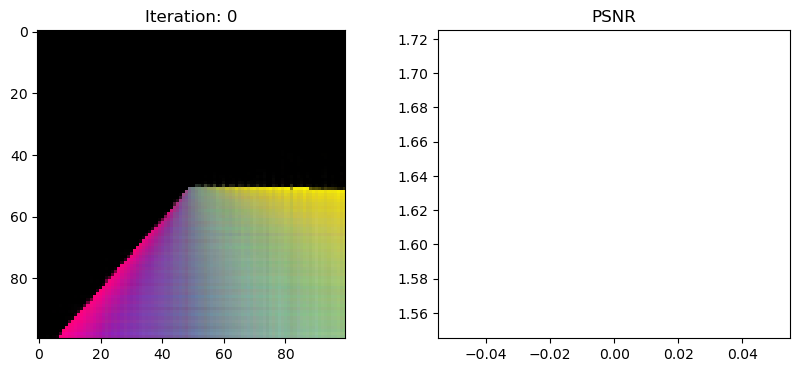

25 29.87216019630432 secs per iter


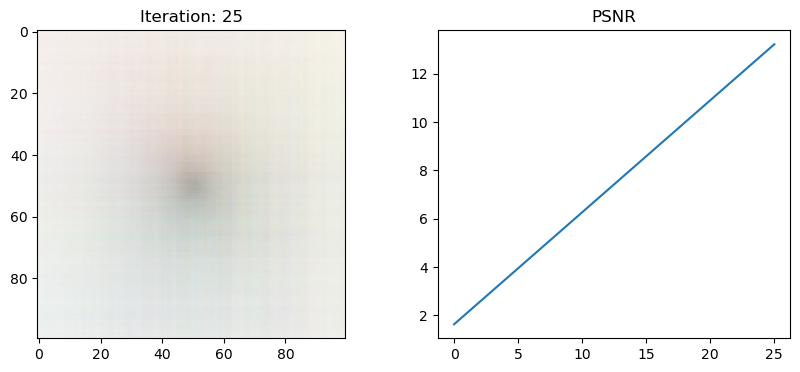

50 28.265411567687988 secs per iter


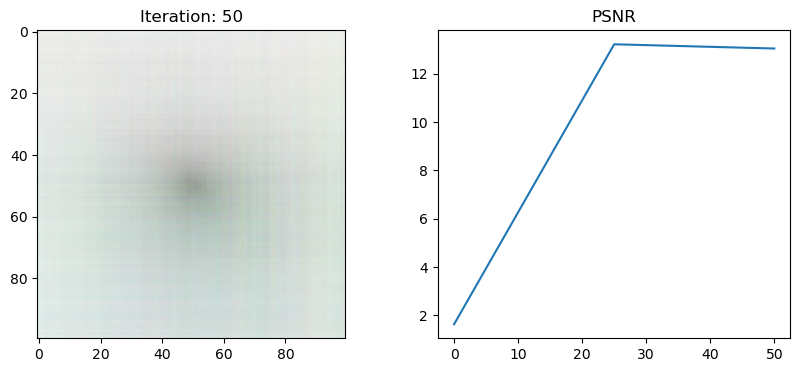

75 31.61056263923645 secs per iter


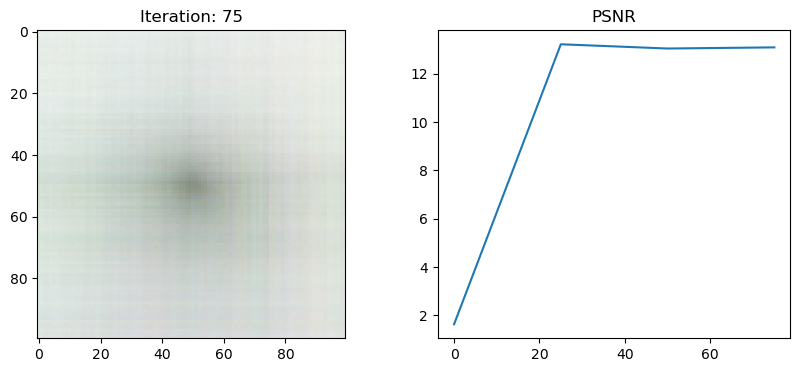

100 30.519805355072023 secs per iter


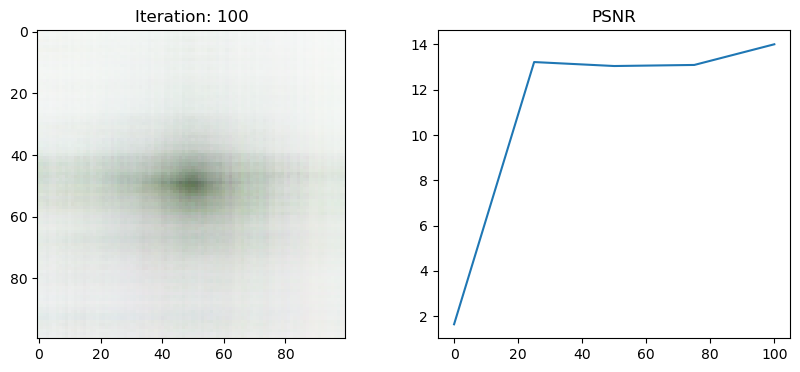

125 32.287054748535155 secs per iter


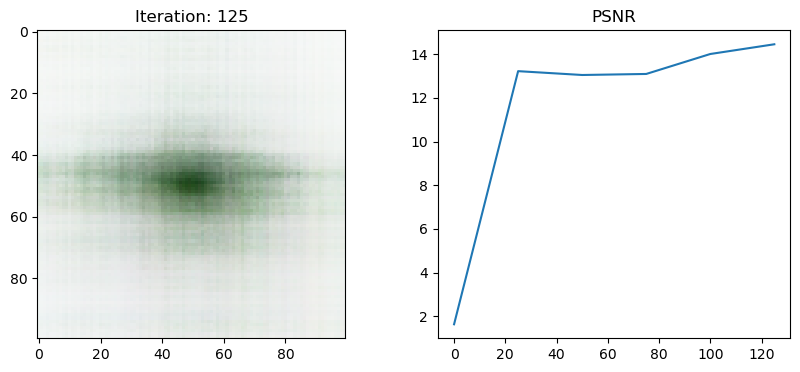

150 33.63786437034607 secs per iter


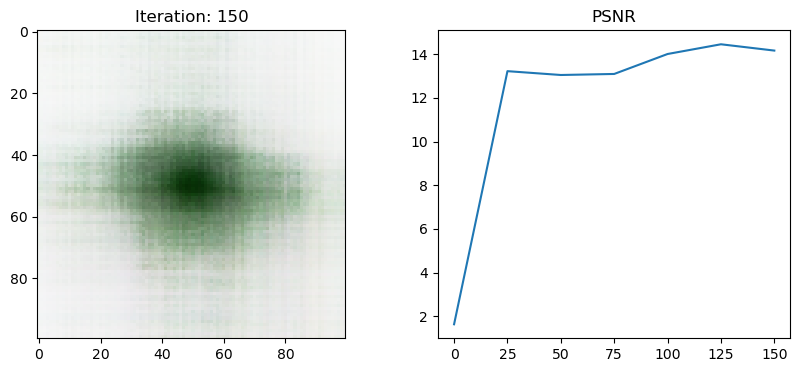

175 31.723492889404298 secs per iter


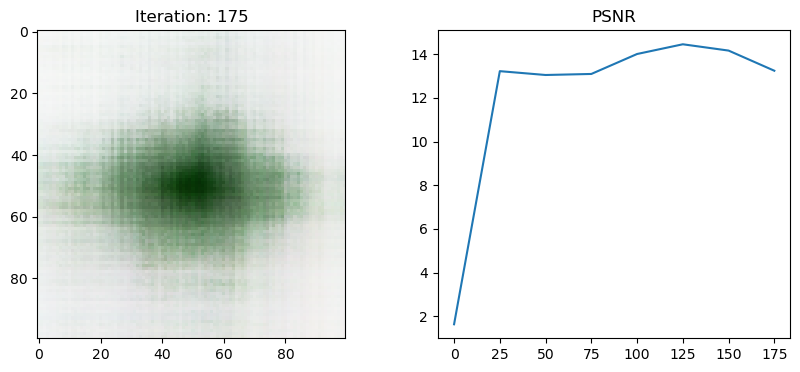

200 32.043218755722044 secs per iter


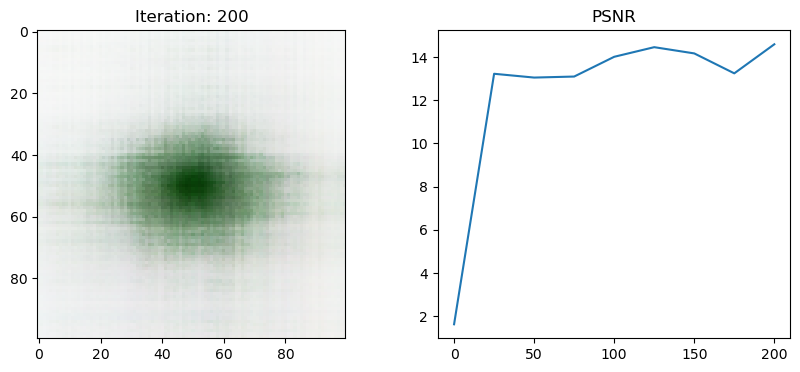

225 33.948884592056274 secs per iter


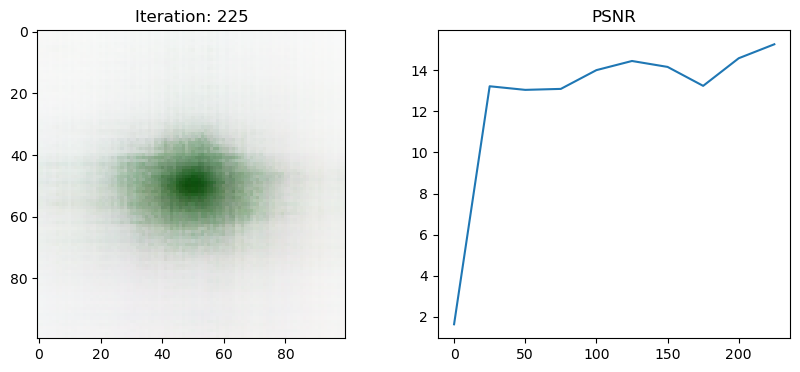

250 36.74879282951355 secs per iter


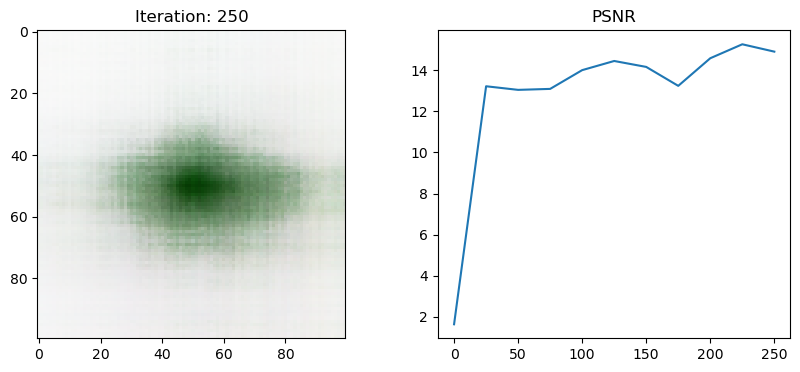

275 37.816545476913454 secs per iter


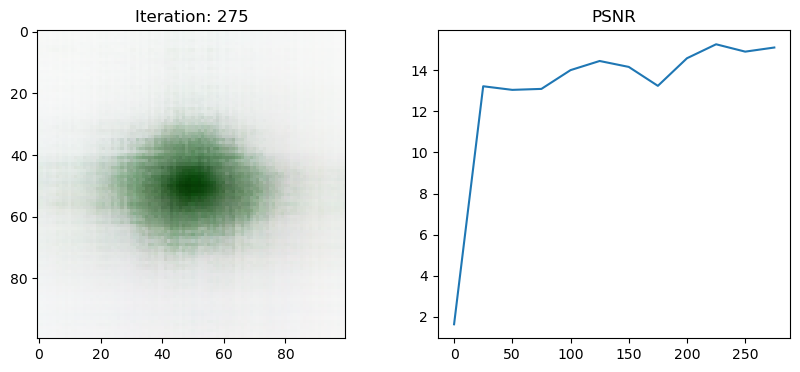

KeyboardInterrupt: 

In [73]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

# Output view and Peak signal-to-noise ratio every 25 iterations
N_samples = 64
N_iters = 1000
psnrs = []
iternums = []
i_plot = 25

import time

t = time.time()
for i in range(N_iters+1):
    
    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=0.1, far=10., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()
        
        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=0.1, far=10., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)
        
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')